## Importations

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import sys
import re, numpy as np, pandas as pd
from pprint import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import spacy
import fr_core_news_md

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Configuration

In [2]:
nlp = fr_core_news_md.load()

In [3]:
config = configparser.ConfigParser()
config.read('../config/default.ini')

['../config/default.ini']

In [4]:
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']))

## Utilitaires

In [19]:
def export_df(df, name):
    df.to_csv('output/{}_{}.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d'), name), index=False, encoding='utf-8-sig')

In [20]:
def clean_html(raw_html):    
    cleanhmtl = re.compile('<.*?>')
    raw_html = raw_html.replace('\n', ' ')
    cleantext = re.sub(cleanhmtl, '', raw_html)
    return cleantext

In [21]:
def sent_to_words(sentences):
    for sent in sentences:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True) ) 

In [44]:
def process_words(texts, stop_words=nlp.Defaults.stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

## Données

In [26]:
df_articles = pd.read_sql_query("""SELECT id, title, mainparagraph FROM article_article art WHERE published = '1' AND EXTRACT(year FROM displaydate) = '2019'""", engine)
df_articles.head()

id                                              title  \
0  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   
1  8236094                     Qui êtes-vous, Jacques Hustin?   
2  8253653  L'asperge est de retour! Florilège de recettes...   
3  8194878  Cette semaine, quelques recettes de pâtes à ta...   
4  8326326              Du gaspacho et de la tatin de tomates   

                                       mainparagraph  
0  <p>Vingt et un ans après Joseph Bruyère, un Wa...  
1  <p>1969. Monique De Lannoy s'entretient avec J...  
2  <p style="text-align:justify;"><strong>Recette...  
3  <p> </p>\n\n<p>Un livre nous sert de référence...  
4  <p style="text-align:justify;"> </p>\n\n<h2 st...

In [27]:
df_articles['mainparagraph'] = df_articles['mainparagraph'].apply(lambda x: clean_html(x))
df_articles.head()

id                                              title  \
0  8226512  Liège-Bastogne-Liège 1999: Vandenbroucke attei...   
1  8236094                     Qui êtes-vous, Jacques Hustin?   
2  8253653  L'asperge est de retour! Florilège de recettes...   
3  8194878  Cette semaine, quelques recettes de pâtes à ta...   
4  8326326              Du gaspacho et de la tatin de tomates   

                                       mainparagraph  
0  Vingt et un ans après Joseph Bruyère, un Wallo...  
1  1969. Monique De Lannoy s'entretient avec Jacq...  
2  Recette 1 - Asperges blanches à l’orange : Ult...  
3     Un livre nous sert de référence en matière ...  
4     Gaspacho Andalou  Ingrédients :  1 kg de to...

In [28]:
df_articles.count()

id               71679
title            71679
mainparagraph    71679
dtype: int64

In [29]:
df_articles.shape

(71679, 3)

In [30]:
df_articles.isnull().any()

id               False
title            False
mainparagraph    False
dtype: bool

---
## Tokenizing 

In [7]:
subset_len = 1000

In [31]:
df_subset = df_articles.head(subset_len) if subset_len > 0 else df_articles.copy()

In [24]:
df_subset['whole_text'] = df_subset.apply(lambda x: '{} {}'.format(x['title'], x['mainparagraph']), axis=1)
data = df_subset.whole_text.values.tolist()
data_words = list(sent_to_words(data))
data_words[:1]

[['liege',
  'bastogne',
  'liege',
  'vandenbroucke',
  'atteint',
  'les',
  'sommets',
  'vingt',
  'et',
  'un',
  'ans',
  'apres',
  'joseph',
  'bruyere',
  'un',
  'wallon',
  'inscrit',
  'son',
  'nom',
  'au',
  'palmares',
  'de',
  'liege',
  'bastogne',
  'liege',
  'est',
  'frank',
  'vandenbroucke',
  'auteur',
  'de',
  'cet',
  'exploit',
  'et',
  'il',
  'ajoute',
  'le',
  'panache',
  'il',
  'avait',
  'annonce',
  'et',
  'il',
  'fait',
  'il',
  'va',
  'gagner',
  'liege',
  'bastogne',
  'liege',
  'et',
  'il',
  'attaquera',
  'dans',
  'la',
  'cote',
  'de',
  'saint',
  'nicolas',
  'endroit',
  'meme',
  'ou',
  'il',
  'avait',
  'du',
  'lacher',
  'prise',
  'lors',
  'de',
  'edition',
  'cette',
  'attitude',
  'resume',
  'elle',
  'seule',
  'le',
  'caractere',
  'et',
  'assurance',
  'de',
  'frank',
  'vandenbroucke',
  'la',
  'fete',
  'depuis',
  'le',
  'debut',
  'du',
  'printemps',
  'le',
  'belge',
  'est',
  'toutefois',
  'pas',


In [25]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
data_ready = process_words(data_words)

In [38]:
df_subset['word_list'] = data_ready
export_df(df_subset, 'articles_tokenized_titles{}'.format('_subset{}'.format(subset_len) if subset_len > 0 else ''))

/home/ubuntu/anaconda3/envs/analytics/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_subset = pd.read_csv('output/{}_articles_tokenized_titles{}.csv'.format(datetime.datetime.strftime(datetime.datetime.now(), '%y%m%d'), '_subset{}'.format(subset_len) if subset_len > 0 else ''))
data_ready = df_subset['word_list'].apply(lambda x: x.strip("']['").split(', '))

In [42]:
coherence_values

[0.2993974237595061,
 0.2993860474306215,
 0.3041249054287757,
 0.29163268441156903,
 0.2953030308908847,
 0.29624688213384315,
 0.28688576131245763,
 0.295317913818823,
 0.2902841723643974,
 0.29071863759738065,
 0.28892001821130275]

In [40]:
coherence_values = [0.2993974237595061,
 0.2993860474306215,
 0.3041249054287757,
 0.29163268441156903,
 0.2953030308908847,
 0.29624688213384315,
 0.28688576131245763,
 0.295317913818823,
 0.2902841723643974,
 0.29071863759738065,
 0.28892001821130275]

In [37]:
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence='c_v'
        )
        coherence = coherencemodel.get_coherence()
        print('model {}: {}'.format(num_topics, coherence))
        coherence_values.append(coherence)
    return model_list, coherence_values

model 135: 0.28922296341930837
model 145: 0.2910662684938927
model 155: 0.29153535347905696
model 165: 0.2931716941227437
model 175: 0.29022626061847784
model 185: 0.28750528156567273
model 195: 0.29230317242421555
model 205: 0.2874182600662769
model 215: 0.28922523853636645
model 225: 0.289470639412267
model 235: 0.2876816019785281
model 245: 0.28756107115022245
model 255: 0.2875191958696073
model 265: 0.28467171381102246
model 275: 0.2856450830756107
model 285: 0.2842694195281343
model 295: 0.28538097101493376


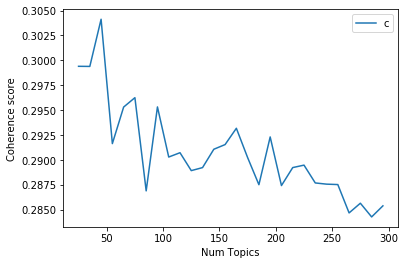

In [43]:
limit=300; start=135; step=10;

model_list, coherence_values = coherence_values_computation (
    dictionary=id2word, corpus=corpus, texts=data_ready, 
    start=start, limit=limit, step=step
)
x = range(25, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready if len(text) ]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

lda_model.print_topics()

[(44,
  '0.000*"liee" + 0.000*"inverse" + 0.000*"restauration" + 0.000*"quoter" + 0.000*"periodicite" + 0.000*"vis_vis" + 0.000*"lallemand" + 0.000*"distinguer" + 0.000*"exposant" + 0.000*"commissaire"'),
 (33,
  '0.000*"liee" + 0.000*"inverse" + 0.000*"restauration" + 0.000*"quoter" + 0.000*"periodicite" + 0.000*"vis_vis" + 0.000*"lallemand" + 0.000*"distinguer" + 0.000*"exposant" + 0.000*"commissaire"'),
 (32,
  '0.000*"liee" + 0.000*"inverse" + 0.000*"restauration" + 0.000*"quoter" + 0.000*"periodicite" + 0.000*"vis_vis" + 0.000*"lallemand" + 0.000*"distinguer" + 0.000*"exposant" + 0.000*"commissaire"'),
 (12,
  '0.000*"liee" + 0.000*"inverse" + 0.000*"restauration" + 0.000*"quoter" + 0.000*"periodicite" + 0.000*"vis_vis" + 0.000*"lallemand" + 0.000*"distinguer" + 0.000*"exposant" + 0.000*"commissaire"'),
 (29,
  '0.098*"jeu" + 0.086*"service" + 0.071*"television" + 0.066*"presente" + 0.064*"analyse" + 0.062*"presse" + 0.047*"radio" + 0.046*"regulierement" + 0.040*"oreille" + 0.040*

In [8]:
lda_model = gensim.models.LdaModel.load('lda{}.model'.format('_subset{}'.format(subset_len) if subset_len > 0 else ''))

In [29]:
coherencemodel = CoherenceModel(
model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v'
)
coherencemodel.get_coherence()

0.2845759460580846

In [42]:
lda_model.save('lda{}.model'.format('_subset{}'.format(subset_len) if subset_len > 0 else ''))

In [44]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
export_df(df_dominant_topic, 'dominant_topics'.format('_subset{}'.format(subset_len) if subset_len > 0 else ''))
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0            32.0              0.8004   
1            1            25.0              0.9017   
2            2            34.0              0.3145   
3            3            58.0              0.4593   
4            4            48.0              0.2557   
5            5            29.0              0.6959   
6            6            34.0              0.6767   
7            7            34.0              0.2997   
8            8            18.0              0.9532   
9            9            29.0              0.7508   

                                            Keywords  \
0  an, grand, annoncer, prendre, passer, cote, co...   
1  belge, remporte, chanson, avril, apporte, entr...   
2  falloir, faire, partie, aller, bon, trouver, n...   
3  jour, petit, semaine, mettre, attendre, prendr...   
4  milieu, disposer, placer, cercle, glace, ingre...   
5  pouvoir, temps, final, but, coupe, connaître, ...   
6  falloir, faire, partie, aller, bon, trouver, n...   
7  falloir, faire, partie, aller, bon, trouver, n...   
8  fois, jeu, service, television, presente, anal...   
9  pouvoir, temps, final, but, coupe, connaître, ...   

                                                Text  
0  [an, inscrire, nom, auteur, exploit, ajoute, p...  
1  [moniqu, entretenir, belge, chanson, poetique,...  
2  [recette, asperges, blanc, ultra, simple, gout...  
3  [livre, servir, reference, matiere, pate, tart...  
4  [gaspacho, ingredient, kilogramme, tomate, rou...  
5  [automne, journee, raccourcir, froid, installe...  
6                                                 []  
7  [cassonade, brun, farine, bicarbonate, cannell...  
8  [cuisson_min, lentille, brun, boite, egouttees...  
9  [silhouette, improbable, evoquer, fois, docteu...

In [45]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.0167   
1       18.0              0.9532   
2       23.0              0.6889   
3       25.0              0.9017   
4       29.0              0.8033   
5       32.0              0.8361   
6       33.0              0.6722   
7       34.0              0.8033   
8       38.0              0.6271   
9       48.0              0.2557   

                                                                                              Keywords  \
0  reflechit, punition, venant, scolaire, renvoi, alternance, reell, enseignement, multiplication, ...   
1          fois, jeu, service, television, presente, analyse, presse, oreille, regulierement, emission   
2                                 livre, sec, sucre, peau, morceau, conserve, min, sel, pate, extraire   
3             belge, remporte, chanson, avril, apporte, entretenir, amour, reflechit, venant, scolaire   
4                        pouvoir, temps, final, but, coupe, connaître, journee, remettre, rock, minute   
5                        an, grand, annoncer, prendre, passer, cote, course, occasion, auteur, edition   
6                   ancien, moment, dur, surface, vente, simple, ouvrir, classique, accompagner, cycle   
7                             falloir, faire, partie, aller, bon, trouver, nuit, forme, hauteur, blanc   
8                        ensembl, terminer, eau, kilogramme, feu, recette, tendre, demi, chinois, plat   
9      milieu, disposer, placer, cercle, glace, ingredient, cm, multiplication, enseignement, scolaire   

                                                                                   Representative Text  
0  [famille, cuisson, tasse, carotte, tasse, huile, tasse, farine, sucre, œuf, baking, powder, sel,...  
1  [cuisson_min, lentille, brun, boite, egouttees, soigneusement, feta, emiettee, legerement, battr...  
2  [bouteille, ml_eau, millilitre, vodka, sucre, sucre_roux, extraire, vanille, extraire, amandes, ...  
3  [moniqu, entretenir, belge, chanson, poetique, espiegle, humoristique, remporte, chanson, soucie...  
4  [jeune, originaire, intercepte, vendredi, police, serieus, entrave, circulation, janvier, indiqu...  
5  [sg, prive, star, neymar, indisponible, blessure, emporte, dimanche, cloture, journee, continuer...  
6  [xv, courrier, reagit, aversion, chef, gouvernement, duc, temoigne, egard, favori, monsieur, ecr...  
7  [em, edition, semaine, derouler, mardi, janvier, dimanche, fevrier, walloni, objectif, decouvrir...  
8  [musiq, invite, concert, rencontre, accordeon, diatonique, violoncelle, orchestr, symphonique, m...  
9  [gaspacho, ingredient, kilogramme, tomate, rouge, mure, concombre, poivron, rouge, oignon, tranc...

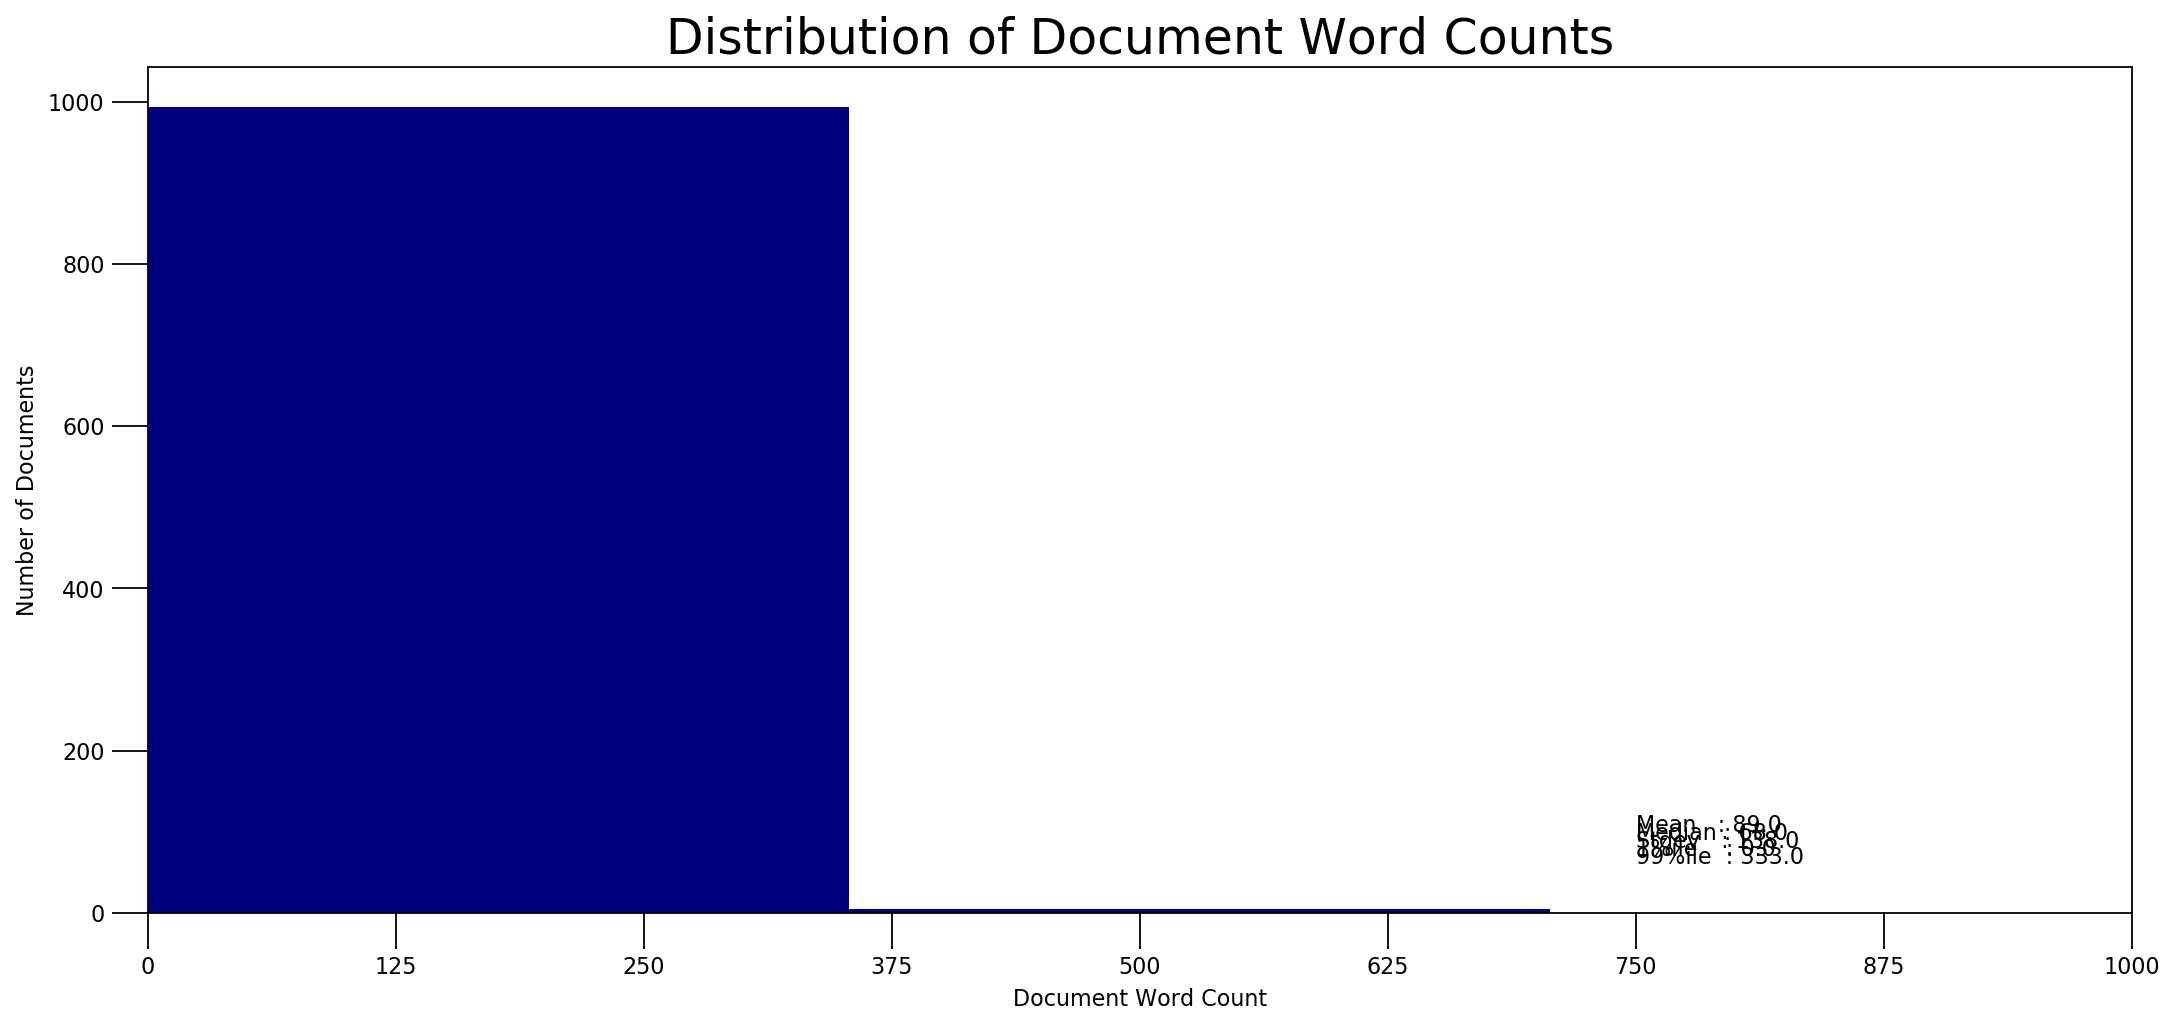

In [46]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [47]:
df_dominant_topic['Dominant_Topic'].unique()

array([32., 25., 34., 58., 48., 29., 18., 23., 33., 38.,  0., 57., nan])

In [51]:
df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 48]

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
4              4            48.0              0.2557   
43            43            48.0              0.1776   
215          215            48.0              0.2542   

                                                                                            Keywords  \
4    milieu, disposer, placer, cercle, glace, ingredient, cm, multiplication, enseignement, scolaire   
43   milieu, disposer, placer, cercle, glace, ingredient, cm, multiplication, enseignement, scolaire   
215  milieu, disposer, placer, cercle, glace, ingredient, cm, multiplication, enseignement, scolaire   

                                                                                                    Text  
4    [gaspacho, ingredient, kilogramme, tomate, rouge, mure, concombre, poivron, rouge, oignon, tranc...  
43   [voyage, poetiqu, musical, humoristique, absurde, julo, beaucarne, musicien, cherche, trouve, ec...  
215  [grand, joie, confier, fatigue, heureux, issu, qualification, belge, ravir, mercredi, soir, hiss...

In [54]:
df_subset.head(1)['mainparagraph']

0    Vingt et un ans après Joseph Bruyère, un Wallon inscrit son nom au palmarès de Liège-Bastogne-Li...
Name: mainparagraph, dtype: object